In [1]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

Note: you may need to restart the kernel to use updated packages.


'C:\Users\T' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

Using TensorFlow backend.


## Helper Function

In [3]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [4]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [5]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')
    
    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')
    
    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

## Generator

In [6]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d
    
    # Input Layer
    in_img = Input(shape=img_shape)
    
    # Downsampling LeakyReLU
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)
    
    # Upsampling ReLU
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)
    
    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    
    return Model(in_img, out_img, name='generator')

## Discriminator

In [7]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)
    
    merged = Concatenate()([in_src_img, in_target_img])
    
    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    
    return Model([in_src_img, in_target_img], out, name='discriminator')

## GAN

In [8]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

## Train GAN model

In [9]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    blue_photo = data[0]
    blue_sketch = data[1]
    
    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')
        
        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):
            
            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))
            
            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            
            d_loss = 0.5 * np.add(d_loss1, d_loss2)
            
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            
            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))
        
        # summarize model performance
#         if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, target_dir)

## Loss Function

In [10]:
#downgrading tensorflow
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)
    
#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)
    
    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)
    
    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))
    
    return tf.reduce_sum(tf.multiply(p_, tf.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)
    
    return (0.2 * px_loss) + (0.8 * ctx_loss)

Instructions for updating:
non-resource variables are not supported in the long term


## Load Dataset

In [11]:
# dataset path
b_photo_path = 'Dataset/Augmented photo/'
b_sketch_path = 'Dataset/Augmented sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

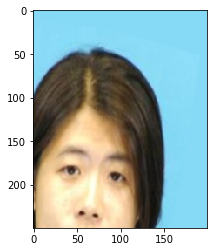

In [12]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))

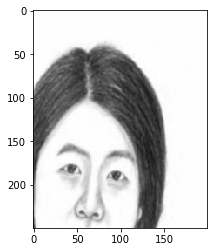

In [13]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))

## Define GAN Model

In [14]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
gan_model.summary()

Model: "GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 256, 256, 3)  41825691    input_4[0][0]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 64, 64, 1)    539203      input_4[0][0]                    
                                                                 generator[1][0]                  
Total params: 42,364,894
Trainable params: 41,825,691
Non-trainable params: 539,203
__________________________________________________________________________________________________


In [16]:
len(g_model.layers)

50

In [17]:
len(d_model.layers)

9

In [18]:
len(gan_model.layers)

3

In [19]:
from keras.optimizers import Adam
opt = Adam(lr=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

## Start Training

In [20]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], 'Models/Pixel[02]_Context[08]/', n_epochs = 100, n_batch=16)

 ========== Epoch 1 ========== 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Batch : 1, D Loss : 1.377 | G Loss : 35.234
Batch : 2, D Loss : 3.650 | G Loss : 14.805
Batch : 3, D Loss : 3.732 | G Loss : 15.714
Batch : 4, D Loss : 3.539 | G Loss : 12.686
Batch : 5, D Loss : 3.536 | G Loss : 13.687
Batch : 6, D Loss : 3.019 | G Loss : 12.440
Batch : 7, D Loss : 3.185 | G Loss : 14.291
Batch : 8, D Loss : 1.339 | G Loss : 15.986
Batch : 9, D Loss : 3.578 | G Loss : 13.051
Batch : 10, D Loss : 3.529 | G Loss : 12.320
Batch : 11, D Loss : 3.549 | G Loss : 13.134
Batch : 12, D Loss : 3.659 | G Loss : 12.348
Batch : 13, D Loss : 3.635 | G Loss : 12.498
Batch : 14, D Loss : 3.467 | G Loss : 12.452
Batch : 15, D Loss : 3.389 | G Loss : 11.930
Batch : 16, D Loss : 3.286 | G Loss : 12.592
Batch : 17, D Loss : 3.318 | G Loss : 12.418
Batch : 18, D Loss : 3.152 | G Loss : 12.064
Batch : 19, D Loss : 3.383 | G Loss : 11.669
Batch : 20, D Loss : 3.351 

Batch : 170, D Loss : 1.255 | G Loss : 8.661
Batch : 171, D Loss : 1.608 | G Loss : 9.236
Batch : 172, D Loss : 1.652 | G Loss : 10.212
Batch : 173, D Loss : 1.569 | G Loss : 8.331
Batch : 174, D Loss : 1.528 | G Loss : 9.229
Batch : 175, D Loss : 3.182 | G Loss : 10.658
Batch : 176, D Loss : 3.223 | G Loss : 10.035
Batch : 177, D Loss : 2.072 | G Loss : 10.791
Batch : 178, D Loss : 1.578 | G Loss : 9.755
Batch : 179, D Loss : 2.538 | G Loss : 10.947
Batch : 180, D Loss : 1.942 | G Loss : 9.643
Batch : 181, D Loss : 2.307 | G Loss : 9.237
Batch : 182, D Loss : 1.715 | G Loss : 8.582
Batch : 183, D Loss : 1.589 | G Loss : 8.558
Batch : 184, D Loss : 2.090 | G Loss : 9.423
Batch : 185, D Loss : 2.195 | G Loss : 9.082
Batch : 186, D Loss : 2.095 | G Loss : 8.730
Batch : 187, D Loss : 2.031 | G Loss : 9.120
Batch : 188, D Loss : 1.992 | G Loss : 8.502
Batch : 189, D Loss : 2.329 | G Loss : 9.217
Batch : 190, D Loss : 2.112 | G Loss : 8.282
Batch : 191, D Loss : 2.051 | G Loss : 8.188
Batch

Batch : 352, D Loss : 2.046 | G Loss : 6.120
Batch : 353, D Loss : 2.160 | G Loss : 6.877
Batch : 354, D Loss : 1.988 | G Loss : 5.734
Batch : 355, D Loss : 1.690 | G Loss : 5.685
Batch : 356, D Loss : 2.447 | G Loss : 16.151
Batch : 357, D Loss : 2.030 | G Loss : 9.638
Batch : 358, D Loss : 1.797 | G Loss : 10.060
Batch : 359, D Loss : 2.220 | G Loss : 11.031
Batch : 360, D Loss : 1.940 | G Loss : 9.456
Batch : 361, D Loss : 1.673 | G Loss : 8.537
Batch : 362, D Loss : 1.779 | G Loss : 8.293
Batch : 363, D Loss : 2.070 | G Loss : 10.327
Batch : 364, D Loss : 1.932 | G Loss : 8.116
Batch : 365, D Loss : 1.912 | G Loss : 8.977
Batch : 366, D Loss : 1.849 | G Loss : 8.192
Batch : 367, D Loss : 1.785 | G Loss : 7.828
Batch : 368, D Loss : 1.839 | G Loss : 7.969
Batch : 369, D Loss : 1.733 | G Loss : 7.808
Batch : 370, D Loss : 2.027 | G Loss : 8.863
Batch : 371, D Loss : 2.173 | G Loss : 9.182
Batch : 372, D Loss : 2.107 | G Loss : 8.769
Batch : 373, D Loss : 2.230 | G Loss : 9.643
Batch 

Batch : 534, D Loss : 2.206 | G Loss : 6.568
Batch : 535, D Loss : 1.843 | G Loss : 5.382
Batch : 536, D Loss : 1.842 | G Loss : 5.250
Batch : 537, D Loss : 2.019 | G Loss : 5.893
Batch : 538, D Loss : 1.826 | G Loss : 5.796
Batch : 539, D Loss : 1.863 | G Loss : 5.498
Batch : 540, D Loss : 1.853 | G Loss : 5.353
Batch : 541, D Loss : 2.008 | G Loss : 6.280
Batch : 542, D Loss : 1.901 | G Loss : 5.762
Batch : 543, D Loss : 2.131 | G Loss : 6.043
Batch : 544, D Loss : 1.935 | G Loss : 5.630
Batch : 545, D Loss : 1.853 | G Loss : 5.209
Batch : 546, D Loss : 1.928 | G Loss : 5.741
Batch : 547, D Loss : 1.680 | G Loss : 4.742
Batch : 548, D Loss : 1.578 | G Loss : 4.625
Batch : 549, D Loss : 1.693 | G Loss : 4.661
Batch : 550, D Loss : 1.570 | G Loss : 4.487
Batch : 551, D Loss : 1.834 | G Loss : 5.634
Batch : 552, D Loss : 1.868 | G Loss : 5.640
Batch : 553, D Loss : 2.146 | G Loss : 6.620
Batch : 554, D Loss : 1.634 | G Loss : 5.755
Batch : 555, D Loss : 2.314 | G Loss : 7.665
Batch : 55

Batch : 717, D Loss : 1.768 | G Loss : 4.815
Batch : 718, D Loss : 2.124 | G Loss : 5.367
Batch : 719, D Loss : 2.385 | G Loss : 6.551
Batch : 720, D Loss : 2.027 | G Loss : 6.043
Batch : 721, D Loss : 2.051 | G Loss : 5.427
Batch : 722, D Loss : 2.137 | G Loss : 5.733
Batch : 723, D Loss : 1.956 | G Loss : 5.894
Batch : 724, D Loss : 1.724 | G Loss : 4.799
Batch : 725, D Loss : 1.955 | G Loss : 5.314
Batch : 726, D Loss : 2.070 | G Loss : 5.645
Batch : 727, D Loss : 1.842 | G Loss : 5.832
Batch : 728, D Loss : 2.050 | G Loss : 6.124
Batch : 729, D Loss : 1.944 | G Loss : 4.891
Batch : 730, D Loss : 2.017 | G Loss : 6.251
Batch : 731, D Loss : 2.093 | G Loss : 6.950
Batch : 732, D Loss : 1.996 | G Loss : 5.600
Batch : 733, D Loss : 2.087 | G Loss : 5.561
Batch : 734, D Loss : 1.873 | G Loss : 5.041
Batch : 735, D Loss : 1.788 | G Loss : 4.583
Batch : 736, D Loss : 1.555 | G Loss : 5.507
Batch : 737, D Loss : 2.128 | G Loss : 6.128
Batch : 738, D Loss : 1.919 | G Loss : 5.308
Batch : 73

Batch : 900, D Loss : 2.101 | G Loss : 5.451
Batch : 901, D Loss : 1.913 | G Loss : 5.088
Batch : 902, D Loss : 2.242 | G Loss : 5.804
Batch : 903, D Loss : 1.795 | G Loss : 5.756
Batch : 904, D Loss : 1.840 | G Loss : 5.694
Batch : 905, D Loss : 2.093 | G Loss : 5.379
Batch : 906, D Loss : 2.215 | G Loss : 5.679
Batch : 907, D Loss : 1.825 | G Loss : 4.794
Batch : 908, D Loss : 1.933 | G Loss : 4.987
Batch : 909, D Loss : 2.064 | G Loss : 5.128
Batch : 910, D Loss : 2.010 | G Loss : 5.298
Batch : 911, D Loss : 2.290 | G Loss : 6.558
Batch : 912, D Loss : 2.173 | G Loss : 5.776
Batch : 913, D Loss : 1.894 | G Loss : 5.446
Batch : 914, D Loss : 1.963 | G Loss : 5.481
Batch : 915, D Loss : 1.804 | G Loss : 4.907
Batch : 916, D Loss : 1.914 | G Loss : 4.940
Batch : 917, D Loss : 2.060 | G Loss : 5.337
Batch : 918, D Loss : 1.729 | G Loss : 4.424
Batch : 919, D Loss : 1.669 | G Loss : 4.328
Batch : 920, D Loss : 2.049 | G Loss : 5.773
Batch : 921, D Loss : 2.033 | G Loss : 6.584
Batch : 92

Batch : 1080, D Loss : 1.981 | G Loss : 7.957
Batch : 1081, D Loss : 1.833 | G Loss : 6.633
Batch : 1082, D Loss : 2.013 | G Loss : 7.018
Batch : 1083, D Loss : 2.178 | G Loss : 7.799
Batch : 1084, D Loss : 1.853 | G Loss : 6.542
Batch : 1085, D Loss : 1.934 | G Loss : 7.013
Batch : 1086, D Loss : 1.890 | G Loss : 6.224
Batch : 1087, D Loss : 1.836 | G Loss : 5.657
Batch : 1088, D Loss : 1.840 | G Loss : 5.611
Batch : 1089, D Loss : 1.834 | G Loss : 5.955
Batch : 1090, D Loss : 2.478 | G Loss : 8.585
Batch : 1091, D Loss : 1.851 | G Loss : 6.082
Batch : 1092, D Loss : 1.888 | G Loss : 6.118
Batch : 1093, D Loss : 2.084 | G Loss : 6.260
Batch : 1094, D Loss : 2.437 | G Loss : 9.996
Batch : 1095, D Loss : 2.385 | G Loss : 7.197
Batch : 1096, D Loss : 2.250 | G Loss : 7.560
Batch : 1097, D Loss : 1.978 | G Loss : 5.933
Batch : 1098, D Loss : 1.989 | G Loss : 6.448
Batch : 1099, D Loss : 1.904 | G Loss : 5.474
Batch : 1100, D Loss : 1.930 | G Loss : 6.363
>Saved: plot_000001.png and g_mode

KeyboardInterrupt: 

In [21]:
g_model_json = g_model.to_json()
with open("g_model.json", "w") as json_file:
    json_file.write(g_model_json)
d_model_json = d_model.to_json()
with open("d_model.json", "w") as json_file:
    json_file.write(d_model_json)

In [22]:
# saving model to H5
g_model.save("g_model1.h5")
d_model.save("d_model1.h5")
print("Saved model to disk")

Saved model to disk


FileNotFoundError: [Errno 2] No such file or directory: 'training_progress.json'